In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")  # suppress general warnings
import json
import subprocess
import re
import nltk
import pandas as pd
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import precision_recall_fscore_support
import concurrent.futures

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/somamohanty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/somamohanty/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import torch
import whisper
import spacy
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging

nlp = spacy.load("en_core_web_sm")


In [3]:
download_path = "downloads"


In [4]:
# --- Helper functions ---
def extract_video_id(embed_url):
    match = re.search(r'embed/([a-zA-Z0-9_-]+)', embed_url)
    return match.group(1) if match else None

def embed_to_full_url(embed_url):
    video_id = extract_video_id(embed_url)
    return f"https://www.youtube.com/watch?v={video_id}" if video_id else None


In [5]:
def fix_audio(input_path):
    temp_path = input_path.replace(".mp3", "_fixed.mp3")
    command = ["ffmpeg", "-y", "-i", input_path, "-acodec", "libmp3lame", temp_path]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if result.returncode == 0:
        os.replace(temp_path, input_path)  # Replace original
        print(f"Audio fixed: {input_path}")
    else:
        print(f"Failed to fix audio: {input_path}")


In [6]:
# ----- Audio Download -----
# Corrected download_audio
def download_audio(video_url, filename_prefix):
    audio_path = os.path.join(download_path, f"{filename_prefix}.mp3")
    command = [
        "yt-dlp", "-x", "--audio-format", "mp3",
        "-o", audio_path,
        video_url
    ]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        print(f"yt-dlp failed for {video_url}")
        print(result.stderr)
        return None
    print(f"Audio downloaded successfully to '{filename_prefix}'")
    return audio_path


In [7]:
# ----- Whisper Transcription -----
def transcribe_audio(audio_path, model_size="small"):
    try:
        model = whisper.load_model(model_size)
        result = model.transcribe(audio_path, language="en")
        return result['text']
    except Exception:
        return None

In [8]:
# ----- Text Cleaning -----
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

In [9]:
# ----- NLP Matching -----
def nlp_matching(transcript_sentences, instruction_texts):
    all_transcript_words = []
    for sent in transcript_sentences:
        all_transcript_words.extend(clean_and_tokenize(sent))
    word_freq = Counter(all_transcript_words)

    matches_nlp = []
    for instruction in instruction_texts:
        instruction_tokens = clean_and_tokenize(instruction)
        best_sentence = ""
        best_score = 0

        for sent in transcript_sentences:
            sent_tokens = clean_and_tokenize(sent)
            match_score = sum(1 / (word_freq[word] + 1) for word in instruction_tokens if word in sent_tokens)

            if match_score > best_score:
                best_score = match_score
                best_sentence = sent

        matches_nlp.append(best_sentence)
    return matches_nlp

In [10]:
# ----- AI Matching -----
def ai_matching(transcript_sentences, instruction_texts):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    transcript_embeddings = model.encode(transcript_sentences, convert_to_tensor=True)
    instruction_embeddings = model.encode(instruction_texts, convert_to_tensor=True)

    matches_ai = []
    for instruction_embedding in instruction_embeddings:
        cosine_scores = util.cos_sim(instruction_embedding, transcript_embeddings)[0]
        best_match_idx = cosine_scores.argmax().item()
        best_match_sentence = transcript_sentences[best_match_idx]
        matches_ai.append(best_match_sentence)
    return matches_ai

In [11]:
# Load models once globally
srl_predictor = Predictor.from_path(
    "https://storage.googleapis.com/allennlp-public-models/structured-prediction-srl-bert.2020.12.15.tar.gz"
)

def extract_features(instr: str):
    """Extract (action, tool, purpose) from an instruction using dependency parsing, NER, and SRL."""
    doc = nlp(instr)
    action, tool, purpose = "", "", ""

    # Dependency parsing to find main verb (action) and its direct object (tool)
    for token in doc:
        if token.pos_ == "VERB" and token.dep_ in ("ROOT", "advcl"):
            action = token.lemma_.capitalize()
            for child in token.children:
                # Prefer dobj or prep -> pobj combo as tool
                if child.dep_ in ("dobj", "attr", "prep"):
                    tool_candidate = child.text
                    try:
                        if child.nbor(1).dep_ == "pobj":
                            tool_candidate += " " + child.nbor(1).text
                    except:
                        pass
                    tool = tool_candidate.strip()
                    break
            break

    # Fallback NER for tool detection
    if not tool:
        for ent in doc.ents:
            if ent.label_ in ("PRODUCT", "WORK_OF_ART", "ORG"):
                tool = ent.text
                break

    # Avoid overly short tools
    if len(tool) <= 2:
        tool = ""

    # SRL for purpose detection
    try:
        srl_result = srl_predictor.predict(sentence=instr)
        for verb in srl_result.get("verbs", []):
            desc = verb["description"]
            if "ARGM-PURP" in desc:
                match = re.search(r'\[ARGM-PURP: (.*?)\]', desc)
                if match:
                    purpose = match.group(1).strip()
                    break
            elif "ARG1" in desc and not purpose:
                match = re.search(r'\[ARG1: (.*?)\]', desc)
                if match:
                    purpose = match.group(1).strip()
    except:
        purpose = ""

    return action, tool, purpose


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
#Extract likely instructional sentences from transcript
def is_instructional(sentence):
    words = word_tokenize(sentence)
    tagged = nltk.pos_tag(words)
    # Check if the sentence has at least one base form or present tense verb
    return any(tag in ["VB", "VBZ", "VBP"] for _, tag in tagged)

def extract_instruction_candidates(transcript_text):
    sentences = sent_tokenize(transcript_text)
    candidates = []
    for s in sentences:
        if len(s.split()) >= 3 and is_instructional(s):
            candidates.append(s.strip())
    return candidates


def deduplicate_sentences(sentences, threshold=0.85):
    embeddings = model.encode(sentences, convert_to_tensor=True)
    keep = []
    seen = []
    for i, sent in enumerate(sentences):
        is_duplicate = False
        for j in seen:
            sim = util.cos_sim(embeddings[i], embeddings[j]).item()
            if sim >= threshold:
                is_duplicate = True
                break
        if not is_duplicate:
            seen.append(i)
            keep.append(sent)
    return keep

def extract_and_filter_instructions(transcript_text):
    raw_candidates = extract_instruction_candidates(transcript_text)
    deduped_instructions = deduplicate_sentences(raw_candidates)
    return deduped_instructions


In [13]:
# ----- Evaluation -----
from sentence_transformers import SentenceTransformer, util

# Load globally ONCE
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_metrics_semantic(instruction_texts, predicted_sentences, default_threshold=0.6, short_threshold=0.5):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    instruction_embeddings = model.encode(instruction_texts, convert_to_tensor=True)
    predicted_embeddings = model.encode(predicted_sentences, convert_to_tensor=True)
    
    correct = 0
    for idx, (true_emb, pred_emb) in enumerate(zip(instruction_embeddings, predicted_embeddings)):
        # Pick shorter threshold if instruction is short
        threshold = short_threshold if len(instruction_texts[idx].split()) <= 4 else default_threshold
        sim = util.cos_sim(true_emb, pred_emb).item()
        if sim >= threshold:
            correct += 1

    precision = correct / len(predicted_sentences)
    recall = correct / len(instruction_texts)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return precision, recall, f1

In [14]:
def process_json(json_path):
    from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound, CouldNotRetrieveTranscript

    try:
        with open(json_path, "r") as f:
            data = json.load(f)

        embed_url = data.get("video_url", None)
        if not embed_url:
            print(f"No embed_url in {json_path}")
            return None, None

        video_url = embed_to_full_url(embed_url)
        video_id = extract_video_id(embed_url)

        if not video_url or not video_id:
            print(f"Invalid video URL or ID in {json_path}")
            return None, None

        # Extract reference steps from JSON
        reference_steps = [v["text"] for k, v in data.items() if k != "video_url"]
        if not reference_steps:
            print(f"No reference steps in {json_path}")
            return None, None

        filename_prefix = os.path.basename(json_path).replace(".json", "")
        audio_path = download_audio(video_url, filename_prefix)
        transcript_text = None

        if audio_path:
            fix_audio(audio_path)
            transcript_text = transcribe_audio(audio_path)

        if not transcript_text:
            try:
                transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=['en'])
                transcript_text = " ".join([seg["text"] for seg in transcript_list])
            except (TranscriptsDisabled, NoTranscriptFound, CouldNotRetrieveTranscript):
                print(f"No English subtitles available for: {video_url}")
                transcript_text = None
            except Exception:
                print(f"Subtitle fallback failed for: {video_url}")
                transcript_text = None

        if audio_path and os.path.exists(audio_path):
            os.remove(audio_path)

        if not transcript_text:
            print(f"No usable transcript for {video_url}")
            return None, None

        # Extract candidate instructions from transcript
        transcript_instructions = extract_and_filter_instructions(transcript_text)
        if not transcript_instructions:
            print(f"No instructional steps extracted from transcript: {video_url}")
            return None, None

        # Match transcript-derived instructions against JSON reference steps
        nlp_matches = nlp_matching(reference_steps, transcript_instructions)
        ai_matches = ai_matching(reference_steps, transcript_instructions)

        # Semantic evaluation
        precision_nlp, recall_nlp, f1_nlp = compute_metrics_semantic(reference_steps, nlp_matches)
        precision_ai, recall_ai, f1_ai = compute_metrics_semantic(reference_steps, ai_matches)

        score_row = {
            "video_url": video_url,
            "precision_nlp": round(precision_nlp, 2),
            "recall_nlp": round(recall_nlp, 2),
            "f1_nlp": round(f1_nlp, 2),
            "precision_ai": round(precision_ai, 2),
            "recall_ai": round(recall_ai, 2),
            "f1_ai": round(f1_ai, 2)
        }

        step_rows = []
        for idx, (inst, nlp_sent, ai_sent) in enumerate(zip(transcript_instructions, nlp_matches, ai_matches), 1):
            action, tool, purpose = extract_features(inst)
            step_rows.append({
                "video_url": video_url,
                "Step_No": idx,
                "Instruction_Text": inst,
                "Action_Type": action,
                "Tool_Product": tool,
                "Purpose_Outcome": purpose,
                "NLP_Matched": nlp_sent,
                "AI_Matched": ai_sent
            })

        return score_row, step_rows

    except Exception as e:
        print(f"Error processing {json_path}: {e}")
        return None, None


In [15]:
# ----- Main Runner -----
def process_all_jsons_parallel(folder_path, max_workers=4):
    scores = []
    steps = []

    all_files = [f for f in os.listdir(folder_path) if f.endswith(".json")][:]
    print(f"Total JSON files found: {len(all_files)}")

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {executor.submit(process_json, os.path.join(folder_path, file_name)): file_name for file_name in all_files}

        for future in concurrent.futures.as_completed(future_to_file):
            file_path = future_to_file[future]
            try:
                score_row, step_rows = future.result()
                if score_row and step_rows:
                    scores.append(score_row)
                    steps.extend(step_rows)
            except Exception as exc:
                print(f"File {file_path} generated an exception: {exc}")

    # Save results
    df_scores = pd.DataFrame(scores)
    df_steps = pd.DataFrame(steps)

    df_scores.to_csv("comparison_scores.csv", index=False)
    df_steps.to_csv("steps_table.csv", index=False)

    print("\n All Done! Files saved as 'comparison_scores.csv' and 'steps_table.csv'.")


Total JSON files found: 2111
Audio downloaded successfully to 'Get-a-Girl-Who-Is-in-a-Relationship-to-Like-You'
Audio downloaded successfully to 'Know-if-You-Love-Someone'
Audio fixed: downloads/Know-if-You-Love-Someone.mp3
Audio fixed: downloads/Get-a-Girl-Who-Is-in-a-Relationship-to-Like-You.mp3
Audio downloaded successfully to 'Clean-a-Lobster'
Audio fixed: downloads/Clean-a-Lobster.mp3
Audio downloaded successfully to 'Peel-and-Core-Apples'
Audio fixed: downloads/Peel-and-Core-Apples.mp3
Audio downloaded successfully to 'Get-Rid-of-Mice-Naturally'
Audio fixed: downloads/Get-Rid-of-Mice-Naturally.mp3
Audio downloaded successfully to 'Play-Hangman'
Audio fixed: downloads/Play-Hangman.mp3
Audio downloaded successfully to 'Mail-a-Letter'
Audio fixed: downloads/Mail-a-Letter.mp3
Audio downloaded successfully to 'Take-Care-of-Swords'
Audio downloaded successfully to 'Make-Milk-Tea'
Audio fixed: downloads/Take-Care-of-Swords.mp3
Audio fixed: downloads/Make-Milk-Tea.mp3
Audio downloaded su

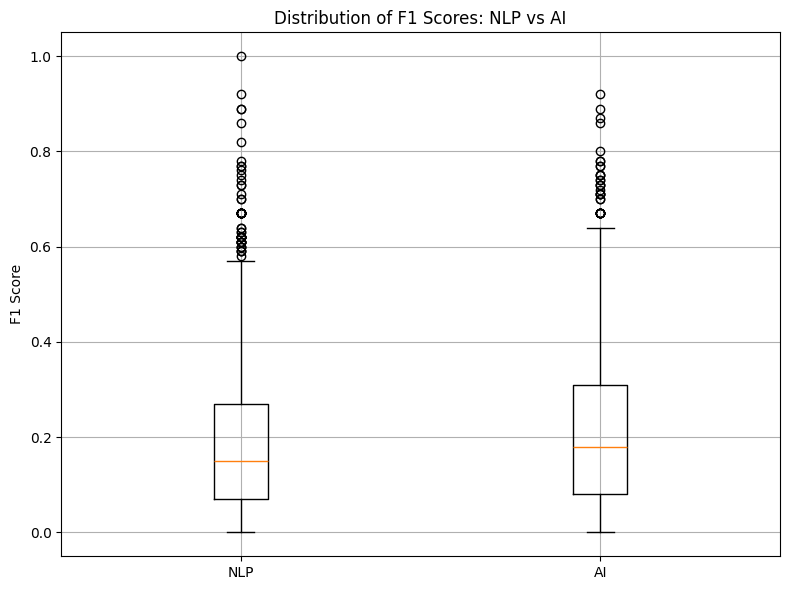

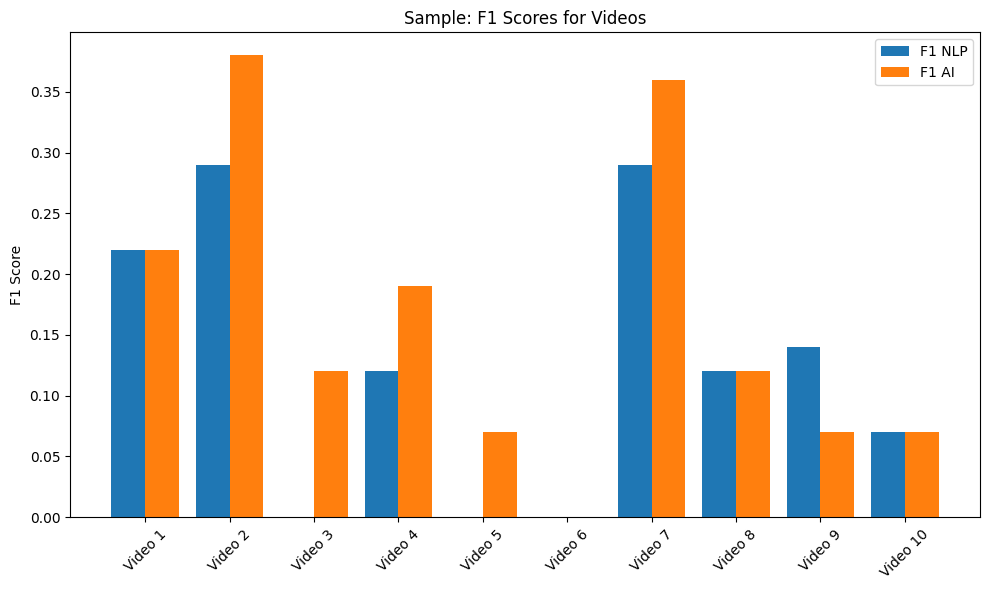

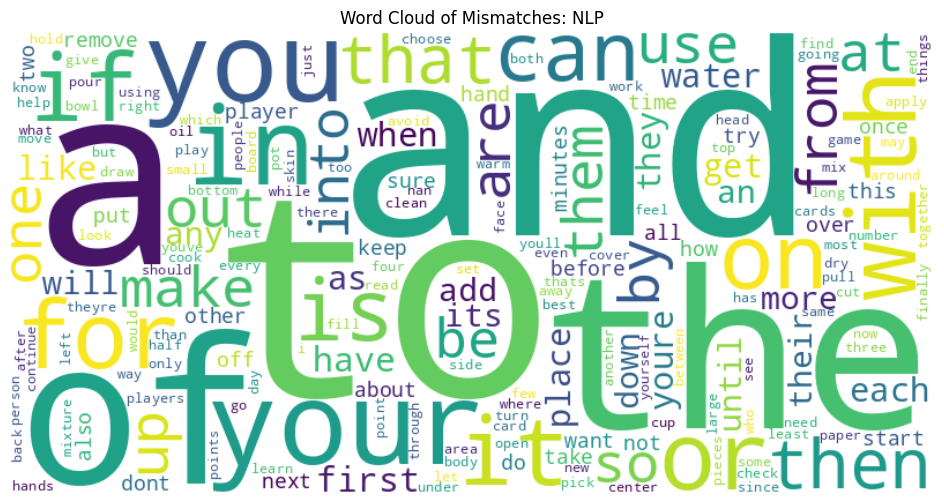

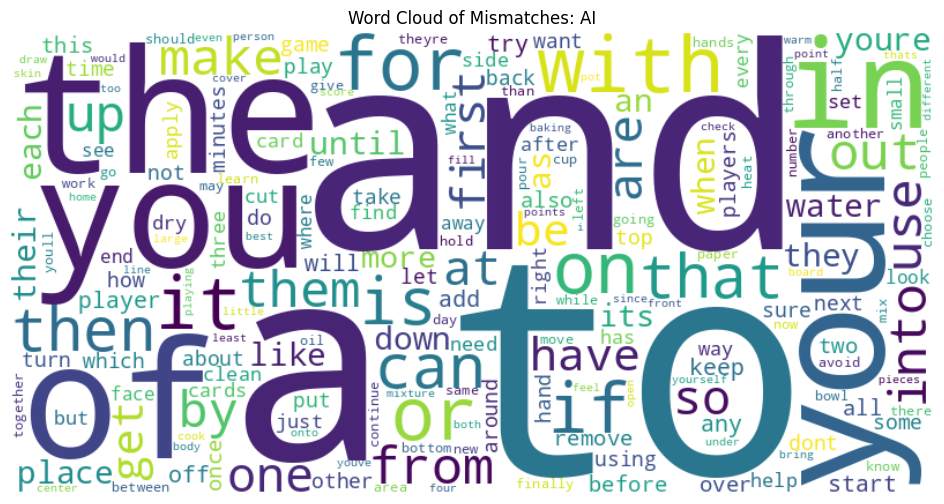

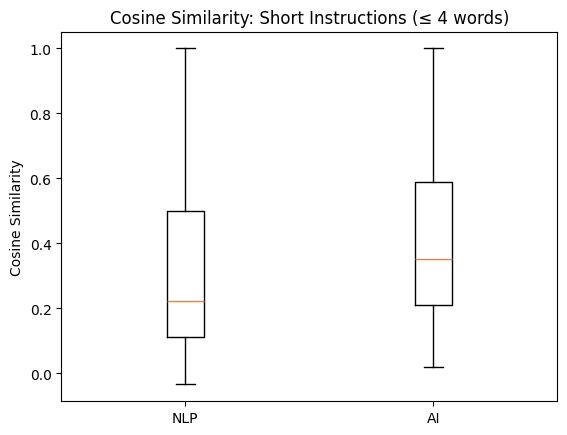

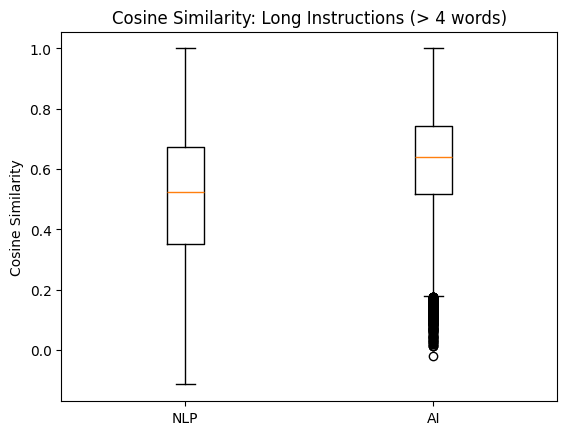

In [16]:
def generate_visualizations(score_csv="comparison_scores.csv", step_csv="steps_table.csv"):
    import pandas as pd
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    from sentence_transformers import SentenceTransformer, util
    import re
    from collections import Counter

    model = SentenceTransformer('all-MiniLM-L6-v2')

    def tokenize(text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        return text.split()

    df_scores = pd.read_csv(score_csv)
    df_steps = pd.read_csv(step_csv)

    # 1. Boxplot of F1 scores
    plt.figure(figsize=(8, 6))
    plt.boxplot([df_scores['f1_nlp'], df_scores['f1_ai']], labels=["NLP", "AI"])
    plt.ylabel("F1 Score")
    plt.title("Distribution of F1 Scores: NLP vs AI")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("viz_f1_boxplot.png")

    # 2. Bar plot for 10 random videos
    sample_size = min(10, len(df_scores))
    if sample_size == 0:
        print("Not enough videos processed to create sample bar chart.")
    else:
        sample_df = df_scores.sample(n=sample_size, random_state=42)
        plt.figure(figsize=(10, 6))
        x = range(len(sample_df))
        plt.bar([i - 0.2 for i in x], sample_df['f1_nlp'], width=0.4, label='F1 NLP')
        plt.bar([i + 0.2 for i in x], sample_df['f1_ai'], width=0.4, label='F1 AI')
        plt.xticks(x, [f"Video {i+1}" for i in x], rotation=45)
        plt.ylabel("F1 Score")
        plt.title("Sample: F1 Scores for Videos")
        plt.legend()
        plt.tight_layout()
        plt.savefig("viz_sample_f1_bar.png")


    # 3. Word Clouds of Mismatches
    nlp_mismatches, ai_mismatches = [], []
    for _, row in df_steps.iterrows():
        instr = set(tokenize(str(row['Instruction_Text'])))
        nlp = set(tokenize(str(row['NLP_Matched'])))
        ai = set(tokenize(str(row['AI_Matched'])))
        nlp_mismatches.extend(instr.symmetric_difference(nlp))
        ai_mismatches.extend(instr.symmetric_difference(ai))

    wc_nlp = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(Counter(nlp_mismatches))
    wc_ai = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(Counter(ai_mismatches))

    plt.figure(figsize=(12, 6))
    plt.imshow(wc_nlp, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Mismatches: NLP")
    plt.savefig("viz_nlp_wordcloud.png")

    plt.figure(figsize=(12, 6))
    plt.imshow(wc_ai, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Mismatches: AI")
    plt.savefig("viz_ai_wordcloud.png")

    # 4. Cosine similarity: Short vs Long instructions
    def cosine_score(a, b):
        return util.cos_sim(model.encode([a])[0], model.encode([b])[0]).item()

    df_steps['len'] = df_steps['Instruction_Text'].str.split().str.len()
    short_nlp, short_ai, long_nlp, long_ai = [], [], [], []

    for _, row in df_steps.iterrows():
        sim_nlp = cosine_score(str(row['Instruction_Text']), str(row['NLP_Matched']))
        sim_ai = cosine_score(str(row['Instruction_Text']), str(row['AI_Matched']))
        if row['len'] <= 4:
            short_nlp.append(sim_nlp)
            short_ai.append(sim_ai)
        else:
            long_nlp.append(sim_nlp)
            long_ai.append(sim_ai)

    # Short instructions
    plt.figure()
    plt.boxplot([short_nlp, short_ai], labels=["NLP", "AI"])
    plt.title("Cosine Similarity: Short Instructions (≤ 4 words)")
    plt.ylabel("Cosine Similarity")
    plt.savefig("viz_short_boxplot.png")

    # Long instructions
    plt.figure()
    plt.boxplot([long_nlp, long_ai], labels=["NLP", "AI"])
    plt.title("Cosine Similarity: Long Instructions (> 4 words)")
    plt.ylabel("Cosine Similarity")
    plt.savefig("viz_long_boxplot.png")

    print("✓ All visualizations saved to PNG files.")

# ---- Run this ----
process_all_jsons_parallel("how_to_steps", max_workers=2)
generate_visualizations()